In [ ]:
#default_exp ocr_dataset_fontsynth

In [ ]:
import numpy as np
import sys,os,shutil, math
import json
import h5py
from PIL import Image, ImageFile
import cv2
import random
from datetime import time
from imgaug import augmenters as iaa
import time

In [ ]:
#export
from ocr.core import *
from pathlib import PosixPath
import pandas as pd

allowed_chars = [

    '0', '1', '2', '3', '4', '5', '6', '7', '8', '9',

    'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 
    'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z',

    'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 
    'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z',
    
    '(', ')', '{', '}', '[', ']', '<', '>', '/', '|', '\\',
    
    ' ', '!', '"', "'", ',', '.', ':', ';', '*', '^', '_', '~',
    
    '+', '=', '-', '!', '#', '$', '%', '&', '?', '@',
    
    'ą', 'č', 'ę', 'ė', 'į', 'š', 'ų', 'ū', 'ž',
    'Ą', 'Č', 'Ę', 'Ė', 'Į', 'Š', 'Ų', 'Ū', 'Ž',
]

class fontsynth_config:
    allowed_chars = allowed_chars
    lang = 'lt'
    wiki_path = PosixPath('../data/wiki')
    gen_dir = PosixPath('../data/fontsynth/')
    bgdir = PosixPath('../data/fontsynth/backgrounds/')
    txtfiles = PosixPath('../data/wiki/lt/docs/')
    fontdir = PosixPath('../data/fontsynth/fonts/')
    LINES_DIR = '../data/ocr/fontsynth_lines/'
    FILE_PATH = '../data/ocr/fontsynth_gt.pickle'
    LINE_HEIGHT = 48
    NUM_EXAMPLES = 50000
    VALID_PCT = .3

len(allowed_chars)

113

### Background

In [ ]:
randn = lambda mean, sigma: np.random.randn()*sigma + mean # [float,float] -> float
rint = lambda x: np.random.randint(x) # [int -> int]
imresize = lambda im,s: cv2.resize(im, dsize=(s[1],s[0])) # [arr,tuple(h,w) -> arr] h,w - ints

class BgGenerator:
    def __init__(self, bgdir=fontsynth_config.bgdir):
        self.bg_images = [np.array(Image.open(fpath)) for fpath in bgdir.iterdir()]
        
    def get_random_bg(self, size=(48,200), p_white=0.1, white=224):
        if np.random.rand() < p_white:
            w, r = white, lambda: randn(0,5)
            white = np.array([ w+r(), w+r(), w+r() ], dtype=np.uint8)
            return np.zeros([size[0], size[1], 3], dtype=np.uint8) + white
        else:
            bg_im = random.choice(self.bg_images)
            h,w,c = bg_im.shape
            # get random crop and resize to
            tl_x, tl_y = rint(w-610), rint(h-110)
            br_x, br_y = tl_x+rint(600)+50, tl_y+rint(100)+10
            return imresize(bg_im[ tl_y:br_y , tl_x:br_x ], size)
        
    def show_examples(self, num_examples=10, size=(48,200), **kwargs):
        canvas = np.zeros([size[0]*num_examples, size[1], 3], dtype=np.uint8)
        for i in range(num_examples):
            canvas[i*size[0]:(i+1)*size[0]] = self.get_random_bg(size=size, **kwargs)
        return plot(canvas, figsize=(10,50))

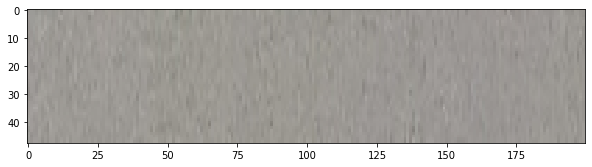

In [ ]:
bg_gen = BgGenerator()
plot(bg_gen.get_random_bg(), figsize=(10,10))

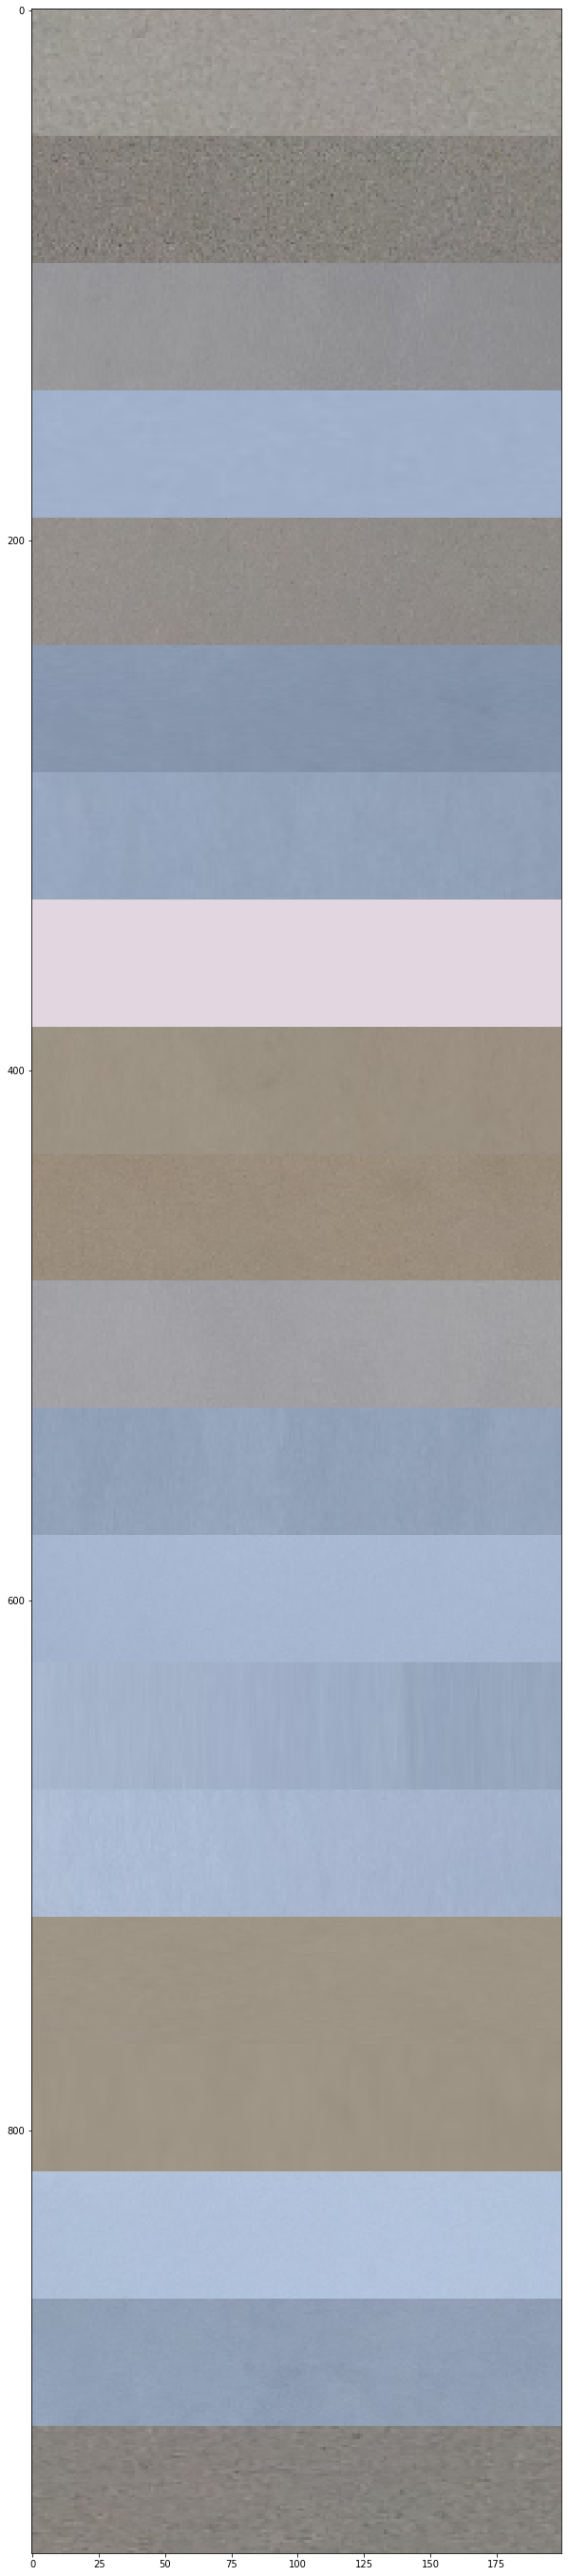

In [ ]:
BgGenerator().show_examples(20, p_white=.1, white=224)

### Wiki Text Download

In [ ]:
from fastai.basics import *
import re

In [ ]:
def get_wiki(path,lang):
    name = f'{lang}wiki'
    if (path/name).exists():
        print(f"{path/name} already exists; not downloading")
        return

    xml_fn = f"{lang}wiki-latest-pages-articles.xml"
    zip_fn = f"{xml_fn}.bz2"

    if not (path/xml_fn).exists():
        print("downloading...")
        download_url(f'https://dumps.wikimedia.org/{name}/latest/{zip_fn}', path/zip_fn)
        print("unzipping...")
        bunzip(path/zip_fn)

    with working_directory(path):
        if not (path/'wikiextractor').exists(): os.system('git clone https://github.com/attardi/wikiextractor.git')
        print("extracting...")
        os.system("python wikiextractor/WikiExtractor.py --processes 4 --no_templates " +
            f"--min_text_length 1800 --filter_disambig_pages --log_file log -b 100G -q {xml_fn}")
    shutil.move(str(path/'text/AA/wiki_00'), str(path/name))
    shutil.rmtree(path/'text')

In [ ]:
def split_wiki(path,lang):
    ''' This function splits the single wikipedia file into a separate file per article. This is often easier to work with. '''
    dest = path/'docs'
    name = f'{lang}wiki'
    if dest.exists():
        print(f"{dest} already exists; not splitting")
        return dest

    dest.mkdir(exist_ok=True, parents=True)
    title_re = re.compile(rf'<doc id="\d+" url="https://{lang}.wikipedia.org/wiki\?curid=\d+" title="([^"]+)">')
    lines = (path/name).open()
    f=None

    for i,l in enumerate(lines):
        if i%100000 == 0: print(i)
        if l.startswith('<doc id="'):
            title = title_re.findall(l)[0].replace('/','_')
            if len(title)>150: continue
            if f: f.close()
            f = (dest/f'{title}.txt').open('w')
        else: f.write(l)
    f.close()
    return dest

In [ ]:
lang = fontsynth_config.lang
name = f'{lang}wiki'
wiki_path = fontsynth_config.wiki_path
lang_path = wiki_path/lang
lang_path.mkdir(exist_ok=True, parents=True)

In [ ]:
get_wiki(lang_path,lang)

../data/wiki/lt/ltwiki already exists; not downloading


In [ ]:
!head -n4 {lang_path}/{name}

<doc id="3" url="https://lt.wikipedia.org/wiki?curid=3" title="Baltai">
Baltai

Baltai, aisčiai – šiaurės rytų Europos gentys kalbėjusios indoeuropiečių kalbų šeimos baltų kalbomis, kilusiomis iš baltų prokalbės. Iki šių laikų iš baltų kalbų išliko tik lietuvių ir latvių kalbos.


In [ ]:
articles_dir = split_wiki(lang_path,lang)

../data/wiki/lt/docs already exists; not splitting


In [ ]:
articles = articles_dir.ls()
articles

[PosixPath('../data/wiki/lt/docs/Demokratija.txt'),
 PosixPath('../data/wiki/lt/docs/Velykos.txt'),
 PosixPath('../data/wiki/lt/docs/Peru.txt'),
 PosixPath('../data/wiki/lt/docs/Europa.txt'),
 PosixPath('../data/wiki/lt/docs/Jungtinės Amerikos Valstijos.txt'),
 PosixPath('../data/wiki/lt/docs/Kalba.txt'),
 PosixPath('../data/wiki/lt/docs/Airija.txt'),
 PosixPath('../data/wiki/lt/docs/Bendroji žemės ūkio politika.txt'),
 PosixPath('../data/wiki/lt/docs/Stanislovas Leščinskis.txt'),
 PosixPath('../data/wiki/lt/docs/Slavai.txt'),
 PosixPath('../data/wiki/lt/docs/Krepšinis.txt'),
 PosixPath('../data/wiki/lt/docs/Imperatorius Karolis V.txt'),
 PosixPath('../data/wiki/lt/docs/Panevėžys.txt'),
 PosixPath('../data/wiki/lt/docs/Sportas.txt'),
 PosixPath('../data/wiki/lt/docs/Chemija.txt'),
 PosixPath('../data/wiki/lt/docs/Vokietija.txt'),
 PosixPath('../data/wiki/lt/docs/Antanas Smetona.txt'),
 PosixPath('../data/wiki/lt/docs/Vilnius.txt'),
 PosixPath('../data/wiki/lt/docs/Sociologija.txt'),
 P

In [ ]:
read = lambda path: open(path).read()

In [ ]:
read(articles[0])[:100]

'Demokratija\n\nDemokratija (gr. "δῆμος" \'liaudis\' + "κρατῶ" \'valdau\') reiškia valdymo formą, kurioje v'

### Corpus

In [ ]:
read = lambda path: open(path).read()

class CorpusGenerator:
    def __init__(self, txtfiles=fontsynth_config.txtfiles, allowed_chars=fontsynth_config.allowed_chars, verbose=0):
        self.allowed_chars = allowed_chars
        txtfiles = txtfiles.iterdir() if is_pathlike(txtfiles) else txtfiles
        self.texts = [read(fpath) for fpath in txtfiles]
        if verbose > 0: print('current chars:', list(self.allowed_chars))
            
    @staticmethod
    def remove_unnecessary_chars(text, white_list):
        pattern = re.compile('[^'+ ''.join([re.escape(i) for i in white_list]) +']')
        return pattern.sub('', text)
    
    @staticmethod
    def remove_trailing_spaces(text):
        text = text if text[0] != ' ' else text[1:] # remove space at start
        text = text if text[-1] != ' ' else text[:-1] # remove space at end
        return text
    
    def get_random_text(self, num_chars):
        text = random.choice(self.texts)
        text = self.remove_unnecessary_chars(text, white_list=self.allowed_chars)
        start_idx = rint(len(text) - num_chars - 10)
        text = text[start_idx:start_idx+num_chars]
        text = self.remove_trailing_spaces(text)
        return text
    
    def show_examples(self, num_examples=10, num_chars=50):
        for i in range(num_examples):
            print(self.get_random_text(num_chars))

In [ ]:
text = read(articles[0])[:100]
print('original:', text)
ptext = CorpusGenerator().remove_unnecessary_chars(text, fontsynth_config.allowed_chars)
print('processed:', ptext)

original: Demokratija

Demokratija (gr. "δῆμος" 'liaudis' + "κρατῶ" 'valdau') reiškia valdymo formą, kurioje v
processed: DemokratijaDemokratija (gr. "" 'liaudis' + "" 'valdau') reiškia valdymo formą, kurioje v


In [ ]:
CorpusGenerator().get_random_text(50)

'džiai buvo švelninami. Per du metus (nuo 1954m. pr'

In [ ]:
CorpusGenerator().show_examples(5, num_chars=50)

suskirstė visas ūmines leukemijas į 3 stambias gr
estinis žodis politikos tarp kitų reikšmių turi ir
iniai daliniai Meliloje ir Ispanijos Maroke bei Ka
81999m. laimėtas Eurolygos čempionatas.Garsiausias
i įrangai. Kitas diskutuotinas atvejis  ar program


### Render Text

In [ ]:
import string
import PIL
from PIL import Image, ImageDraw, ImageFont

In [ ]:
class TextGenerator:
    def __init__(self, fontdir=fontsynth_config.fontdir, verbose=0):
        self.fonts = {fpath.stem:str(fpath) for fpath in fontdir.iterdir()}
        if verbose > 0: print('current fonts:', list(self.fonts.keys()))
            
    @staticmethod
    def text2image(text, text_size, font_path, out_size=None, text_color=(0,0,0), text_loc=None, pad_pct=0.1):
        '''
        @param: str
        @param: int(10-200) :font size, returns similar height in pixels (when using w/ out_size its similar to dpi)
        @param: Path
        @param: int or tuple(2) :if tuple then [height,width] of output, if int then height (width calced auto)
        ...
        @param: float :added pad (pad = text_size*pad_pct)
        '''
        text_loc = (text_size,text_size) if text_loc is None else text_loc
        font = ImageFont.FreeTypeFont(font_path, size=text_size)
        bg_im = PIL.Image.fromarray(np.zeros([400,10000,3], dtype=np.uint8)+255)
        ImageDraw.Draw(bg_im).text(text_loc, text, fill=tuple(listify(text_color)), font=font)
        big_im = np.array(bg_im) # [h,w,3]
        # return copped text
        im = np.sum(big_im-255, axis=-1) # [h,w]
        w_mask = np.sum(im, axis=0) # [w]
        h_mask = np.sum(im, axis=1) # [h]
        h_mask = np.arange(len(h_mask))[h_mask > 0]
        w_mask = np.arange(len(w_mask))[w_mask > 0]
        p, r = pad_pct, lambda: randn(0,0.05)
        pad_pct = np.clip(np.array([pad_pct]*4) + np.array([r()]*4), 0.01, 1)
        pad = (pad_pct*text_size).astype(int)
        tl_x, br_x = max(w_mask[0]-pad[0],0), min(w_mask[-1]+pad[1],im.shape[1])
        tl_y, br_y = max(h_mask[0]-pad[2],0), min(h_mask[-1]+pad[3],im.shape[0])
        text_im = big_im[ tl_y:br_y , tl_x:br_x ]
        if out_size is None:
            return text_im
        elif len(listify(out_size)) > 1: # [h,w]
            return imresize(text_im, out_size)
        else: # out_size = height
            height = listify(out_size)[0]
            width = height / text_im.shape[0] * text_im.shape[1]
            return imresize(text_im, (height, int(width)))
        return text_im
    
    def gen_random_image(self, text, out_size=48): # out_size can be tuple(2) or int
        font = random.choice(list(self.fonts.keys()))
        color = np.array([rint(20)]*3) + int(randn(0,4))
        im = self.text2image(text, text_size=rint(100)+10, font_path=self.fonts[font], text_color=color, pad_pct=(rint(4)+1.5)/10, out_size=out_size)
        return im, font
    
    def show_examples(self, text, num_examples=10, out_size=48, canvas_width=500, **kwargs):
        
        imgs = []
        max_width = 0
        for i in range(num_examples):
            im, font = self.gen_random_image(text, out_size=out_size, **kwargs)
            imgs.append(im)
            if im.shape[1] > max_width: max_width = im.shape[1]
        
        size = out_size if len(listify(out_size)) > 1 else (out_size, max_width)
        canvas = np.zeros([size[0]*num_examples, size[1], 3], dtype=np.uint8)
        for i,im in zip(range(num_examples), imgs):
            canvas[i*size[0]:(i+1)*size[0], :im.shape[1]] = im
        return plot(canvas, figsize=(10,50))
            
TextGenerator(verbose=1)

current fonts: ['Verdana_Italic', 'Georgia_Bold', 'Verdana_Bold', 'Courier_New_Bold_Italic', 'Georgia_Bold_Italic', 'Comic_Sans_MS_Bold', 'Courier_New', 'Arial_Bold', 'Impact', 'Times_New_Roman_Bold', 'Trebuchet_MS_Italic', 'Arial_Bold_Italic', 'Arial_Black', 'Times_New_Roman_Bold_Italic', 'Times_New_Roman_Italic', 'Trebuchet_MS_Bold', 'Verdana', 'Andale_Mono', 'Comic_Sans_MS', 'Courier_New_Italic', 'Verdana_Bold_Italic', 'Trebuchet_MS', 'Arial', 'Times_New_Roman', 'Georgia', 'Arial_Italic', 'Courier_New_Bold', 'Georgia_Italic', 'Trebuchet_MS_Bold_Italic']


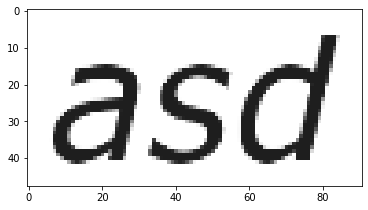

In [ ]:
f = {fpath.stem:str(fpath) for fpath in fontsynth_config.fontdir.iterdir()}
plot(TextGenerator().text2image('asd', 100, f['Verdana_Italic'], out_size=48, text_color=tuple([30]*3), pad_pct=.1))

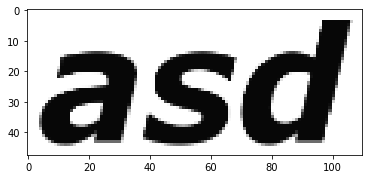

In [ ]:
img, font = TextGenerator().gen_random_image('asd')
plot(img)

enių buvo smarkiai išnaikinta holokausto (19411944


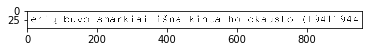

In [ ]:
t = CorpusGenerator().get_random_text(50)
f = {fpath.stem:str(fpath) for fpath in fontsynth_config.fontdir.iterdir()}
print(t)
plot(TextGenerator().gen_random_image(t)[0])

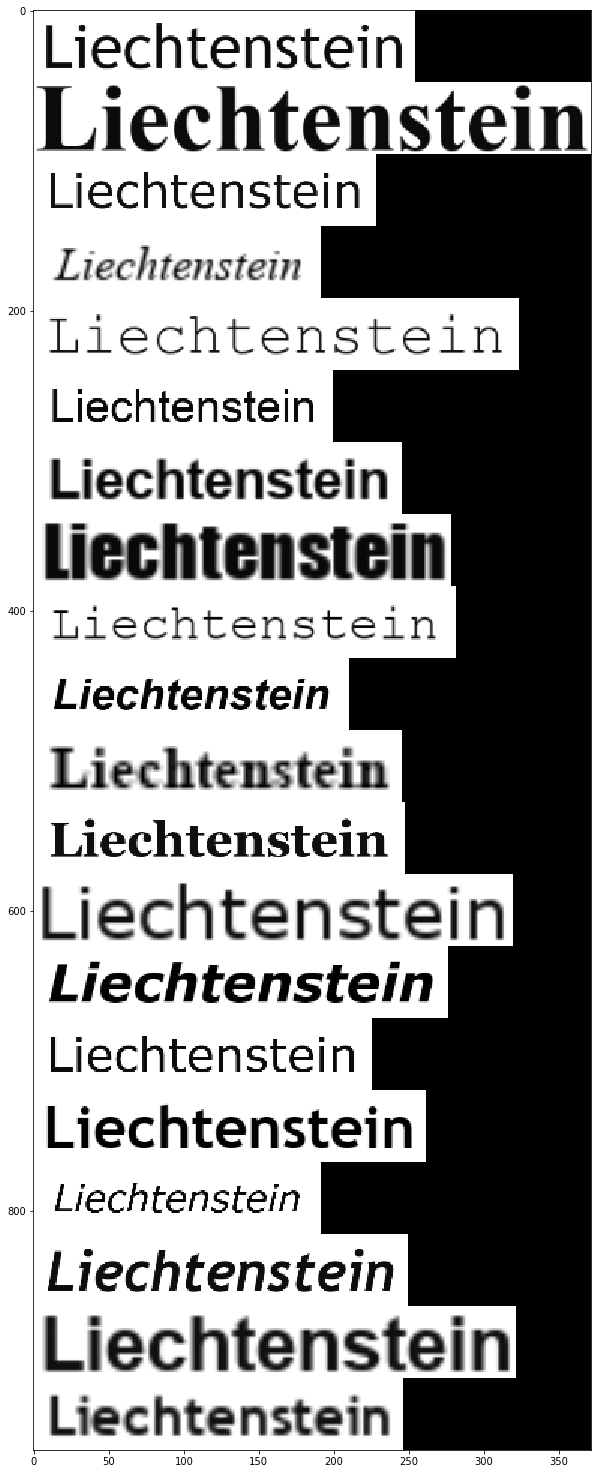

In [ ]:
TextGenerator().show_examples('Liechtenstein', 20)

### Text Image Noise

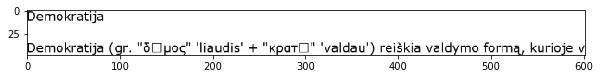

In [ ]:
textim, font = TextGenerator().gen_random_image(text)
plot(textim, figsize=(10,10))

In [ ]:
def iaa_lambda(func):
    return lambda imgs,*args: [func(im) for im in imgs]

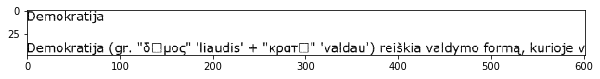

In [ ]:
def small_random_addition():
    def f(img):
        img = img.astype(np.int)
        gauss = np.random.normal(0, 20, tuple(img.shape[:2]))
        gauss = np.clip(gauss, 0, 100)
        gauss = gauss.reshape(list(img.shape[:2]) + [1])
        img = img + gauss
        img = np.clip(img, 0, 255)
        return img.astype(np.uint8)
    return iaa.Lambda(func_images=iaa_lambda(f))

plot(small_random_addition()(images=[textim])[0], figsize=(10,10))

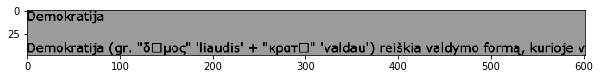

In [ ]:
def subtraction(value):
    def f(img):
        img = img.astype(np.int) - value
        img = np.clip(img, 0, 255)
        return img.astype(np.uint8)
    return iaa.Lambda(func_images=iaa_lambda(f))

plot(subtraction(100)(images=[textim])[0], figsize=(10,10))

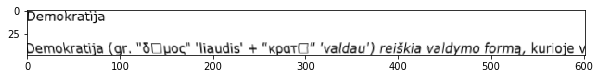

In [ ]:
plot(iaa.PiecewiseAffine(scale=(0.001, 0.006))(images=[textim])[0], figsize=(10,10))

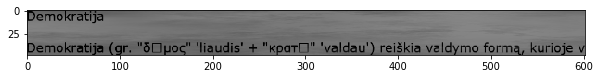

In [ ]:
dark_clouds = iaa.Sequential([iaa.Clouds(), subtraction(120)])
plot(dark_clouds(images=[textim])[0], figsize=(10,10))

In [ ]:
class TextNoiseGenerator:
    def __init__(self):
        
        self.apply_warp = iaa.Sequential([
            iaa.Sometimes(0.4, iaa.PiecewiseAffine(scale=(0.001, 0.005))),
            iaa.Sometimes(0.7, iaa.Affine(translate_px={"x": (-6,6), "y": (-6,6)}, cval=255)),
            iaa.Sometimes(0.8, iaa.Affine(scale=(0.9, 1.0), cval=255)),
        ])
        
        self.apply_noise = iaa.Sequential(
            [        
#                 iaa.Sometimes(0.3, iaa.AdditivePoissonNoise(30)), # small noise
                iaa.Sometimes(0.6, 
                    iaa.SomeOf((2, 4),
                        iaa.Sequential([
                            iaa.Pepper(0.1),
                            iaa.Salt(0.01),
                            iaa.Emboss(alpha=(0.0, 1.0), strength=(0.5, 1.5)), # idk small noise
                            iaa.AllChannelsCLAHE() 
                        ]),
                    )
                 ),

                iaa.Sometimes(0.1, iaa.KMeansColorQuantization(n_colors=8)),
                iaa.Sometimes(0.1, dark_clouds),

                iaa.Sometimes(0.2, 
                    iaa.OneOf([
                        iaa.GaussianBlur((0, 3.0)), # blur images with a sigma between 0 and 3.0
                        iaa.AverageBlur(k=(1, 5)), # blur image using local means with kernel sizes between 2 and 7
                        iaa.MedianBlur(k=(1, 5)), # blur image using local medians with kernel sizes between 2 and 7
                    ]),
                 ),
                
                iaa.Sometimes(0.2, iaa.AdditiveGaussianNoise(loc=50, scale=(20, 70), per_channel=0)),
#                 iaa.JpegCompression(compression=(70, 99))
            ],
            random_order=True
        )
    
    def img2noisyimg(self, img): # make sure bg is 255.
        txt_mask = img != 255
        img = self.apply_noise(images=[img])[0]
        out_im = np.zeros_like(img) + 255
        out_im.reshape(-1)[txt_mask.reshape(-1)] = img.reshape(-1)[txt_mask.reshape(-1)]
        out_im = self.apply_warp(images=[out_im])[0]
        return out_im
    
    def show_examples(self, img, num_examples=10, **kwargs):
        size = img.shape[:2]
        canvas = np.zeros([size[0]*num_examples, size[1], 3], dtype=np.uint8)
        for i in range(num_examples):
            im = self.img2noisyimg(img, **kwargs)
            canvas[i*size[0]:(i+1)*size[0], :im.shape[1]] = im
        return plot(canvas, figsize=(10,50))

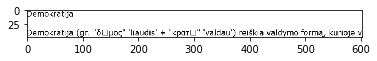

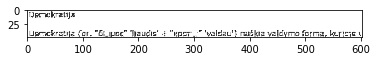

In [ ]:
plot(textim)
plot(TextNoiseGenerator().img2noisyimg(textim))

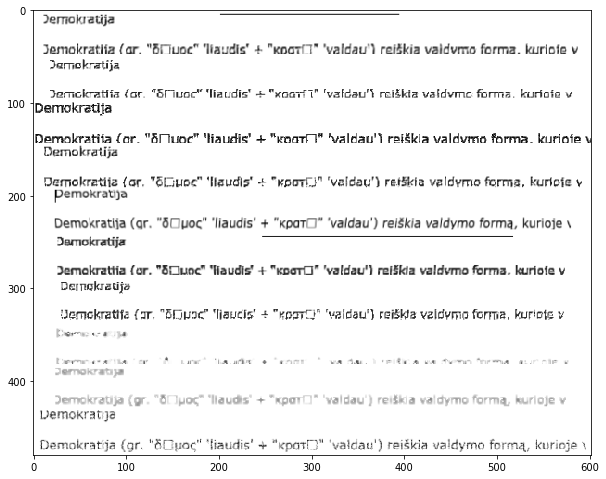

In [ ]:
TextNoiseGenerator().show_examples(textim, 10)

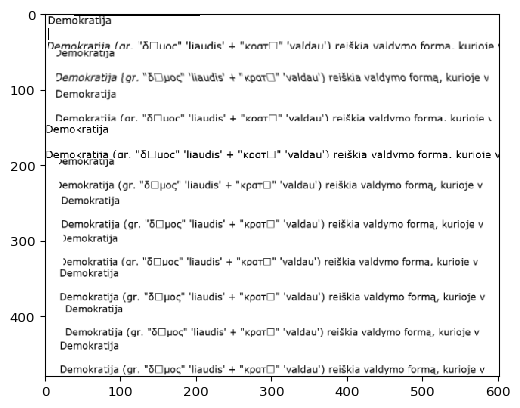

In [ ]:
TextNoiseGenerator().apply_warp.show_grid(textim, cols=1, rows=10)

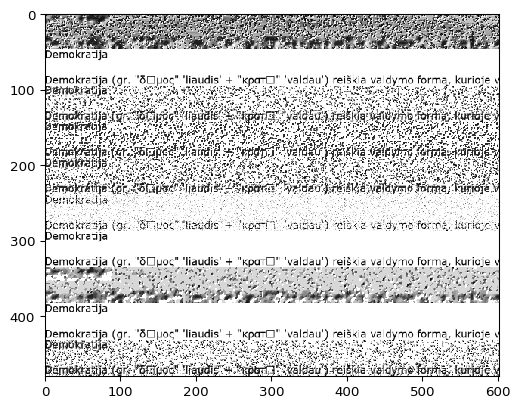

In [ ]:
TextNoiseGenerator().apply_noise.show_grid(textim, cols=1, rows=10)

### Main Generator

In [ ]:
class MainGenerator:
    def __init__(self, im_height=fontsynth_config.LINE_HEIGHT):
        self.im_height = im_height
        self.imtext_gen = TextGenerator()
        self.bg_gen = BgGenerator()
        self.text_gen = CorpusGenerator()
        self.imtext_noise_gen = TextNoiseGenerator()
        
    @staticmethod
    def place_text_on_bg(txt_im, bg_im, txt_opacity=.5): # recommended opacity: .5 - .8
        txt_im = txt_im.astype(int)
        txt_im = 255. - txt_im
        m = txt_im != 0
        txt_im[m] = np.clip(txt_im[m] - (1-txt_opacity)*100, 0, 255) # * bg_im.mean()
        return np.clip(bg_im.astype(int) - txt_im.astype(int), 0, 255).astype(np.uint8)
        
    def gen_item(self, num_chars=50):
        ''' returns img (np.arr), text (str), font (str) '''
        text = self.text_gen.get_random_text(num_chars)
        imtext, font = self.imtext_gen.gen_random_image(text, out_size=self.im_height)
        imtext = self.imtext_noise_gen.img2noisyimg(imtext)
        imbg = self.bg_gen.get_random_bg(size=imtext.shape[:2])
        im = self.place_text_on_bg(imtext, imbg, txt_opacity=(rint(4)+6)/10)
        return im, text, font
    
    def show_examples(self, num_chars=50, num_examples=10, **kwargs):
        imgs = []
        max_width = 0
        for i in range(num_examples):
            im, text, font = self.gen_item(num_chars, **kwargs)
            imgs.append(im)
            if im.shape[1] > max_width: max_width = im.shape[1]
        
        canvas = np.zeros([self.im_height*num_examples, max_width, 3], dtype=np.uint8)
        for i,im in zip(range(num_examples), imgs):
            canvas[i*self.im_height:(i+1)*self.im_height, :im.shape[1]] = im
        return plot(canvas, figsize=(10,50))

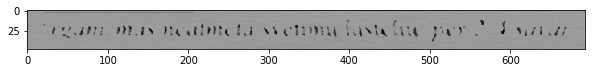

In [ ]:
generator = MainGenerator()

im, text, font = generator.gen_item(num_chars=50)
plot(im, figsize=(10,10))

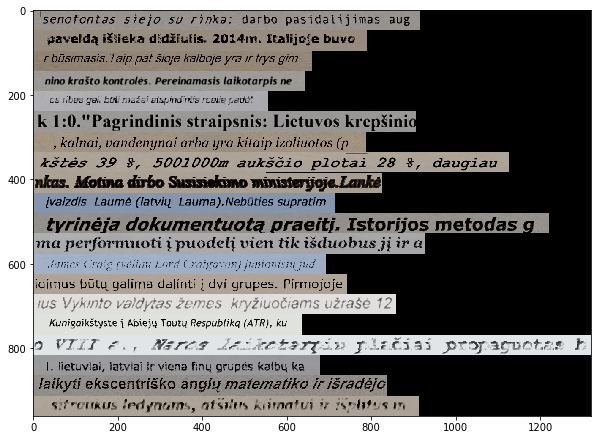

In [ ]:
MainGenerator().show_examples(num_chars=50, num_examples=20)

### Create dataset loop

In [ ]:
generator = MainGenerator()

errors = 0

gt_dict = {}
for i in progress_bar(range(fontsynth_config.NUM_EXAMPLES)):
    try:
        mode = 'train' if i > fontsynth_config.VALID_PCT*fontsynth_config.NUM_EXAMPLES else 'test'
        line_fn = str(i) + '.jpg'
        im, text, font = generator.gen_item(num_chars=rint(20)+20)
        gt_dict[line_fn] = (text, mode, font)
        cv2.imwrite(os.path.join(fontsynth_config.LINES_DIR, line_fn), im)
    except:
        errors += 1
print('num errors:', errors)
save_dict(gt_dict, fontsynth_config.FILE_PATH)

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [ ]:
errors

0

In [ ]:
#export
def get_fn2label():
     return read_dict(fontsynth_config.FILE_PATH)

In [ ]:
#export
def create_df(fn2label=None):
    if fn2label is None: fn2label = get_fn2label()
    data = []
    for fn, (label, data_split, dataset_desc) in fn2label.items():
        data.append((fn, label, data_split == 'test', dataset_desc))
    return pd.DataFrame(data, columns=['image_path', 'string', 'valid', 'dataset'])

In [ ]:
main_df = create_df()
main_df

,image_path,string,valid,dataset
0,0.jpg,je yra vartai į Akropolį. Pr,True,Georgia
1,1.jpg,s ledas. Kasmet užšąla Botnijos,True,Times_New_Roman_Bold
2,2.jpg,"ešimus ir kitus kongreso dokumentus,",True,Georgia_Bold_Italic
3,3.jpg,umas kritikų nebuvo sutikta,True,Courier_New_Bold
4,4.jpg,Rusijos ir Lietuvos metraščiuo,True,Courier_New
...,...,...,...,...
49995,49995.jpg,krato mokymas pateikiamas p,False,Times_New_Roman_Bold_Italic
49996,49996.jpg,os kontrrevoliucinės veiklos. Iš dalies,False,Andale_Mono
49997,49997.jpg,"is. Jau net filmuke darbininkai, i",False,Courier_New_Bold_Italic
49998,49998.jpg,čių eiti anksti ryte į bažnyči,False,Trebuchet_MS


In [ ]:
char_freq = defaultdict(lambda: 0)
for string in main_df['string']:
    for char in string:
        char_freq[char] += 1
char_freq = dict(char_freq)

In [ ]:
char_freq = dict(sorted(char_freq.items(), key=lambda k:k[1]))
print(char_freq)

{'`': 3, '$': 3, '&': 4, 'Q': 7, ']': 14, '[': 17, '*': 19, '?': 19, '~': 27, '|': 29, 'q': 32, '!': 36, 'Ū': 42, '>': 65, '<': 67, 'Y': 80, '_': 80, 'Z': 82, 'x': 105, '+': 111, 'Į': 118, '=': 124, 'W': 126, '/': 131, "'": 136, 'w': 158, 'Č': 172, 'U': 202, ';': 236, '%': 481, 'Ž': 485, 'F': 503, 'O': 510, 'C': 524, 'H': 563, '-': 816, ':': 921, 'Š': 1024, 'X': 1083, 'G': 1091, 'N': 1190, '7': 1236, '6': 1252, 'E': 1331, '4': 1413, '8': 1423, 'M': 1501, '3': 1583, 'J': 1659, 'B': 1663, 'D': 1670, 'R': 1681, '5': 1704, 'L': 1746, 'h': 1871, 'ę': 2138, 'T': 2366, '2': 2432, 'S': 2494, 'I': 2622, '9': 2684, '"': 2685, 'A': 2872, 'K': 2997, 'V': 3038, '0': 3362, 'P': 3502, ')': 3686, '(': 3703, 'f': 3824, 'z': 4043, '1': 4836, 'ū': 4870, 'č': 5023, 'į': 5912, 'c': 6432, 'ą': 7634, 'ž': 9394, 'š': 12233, 'b': 15668, 'y': 16624, 'ė': 17674, 'ų': 17750, '.': 18061, ',': 18377, 'g': 20651, 'v': 25951, 'j': 27463, 'd': 28630, 'p': 31386, 'l': 39217, 'm': 42216, 'k': 47857, 'u': 52494, 'n': 596

In [ ]:
#export
char_freq = {'`': 3, '$': 3, '&': 4, 'Q': 7, ']': 14, '[': 17, '*': 19, '?': 19, '~': 27, '|': 29, 
             'q': 32, '!': 36, 'Ū': 42, '>': 65, '<': 67, 'Y': 80, '_': 80, 'Z': 82, 'x': 105, 
             '+': 111, 'Į': 118, '=': 124, 'W': 126, '/': 131, "'": 136, 'w': 158, 'Č': 172, 
             'U': 202, ';': 236, '%': 481, 'Ž': 485, 'F': 503, 'O': 510, 'C': 524, 'H': 563, 
             '-': 816, ':': 921, 'Š': 1024, 'X': 1083, 'G': 1091, 'N': 1190, '7': 1236, '6': 1252, 
             'E': 1331, '4': 1413, '8': 1423, 'M': 1501, '3': 1583, 'J': 1659, 'B': 1663, 'D': 1670, 
             'R': 1681, '5': 1704, 'L': 1746, 'h': 1871, 'ę': 2138, 'T': 2366, '2': 2432, 'S': 2494, 
             'I': 2622, '9': 2684, '"': 2685, 'A': 2872, 'K': 2997, 'V': 3038, '0': 3362, 'P': 3502, 
             ')': 3686, '(': 3703, 'f': 3824, 'z': 4043, '1': 4836, 'ū': 4870, 'č': 5023, 'į': 5912, 
             'c': 6432, 'ą': 7634, 'ž': 9394, 'š': 12233, 'b': 15668, 'y': 16624, 'ė': 17674, 
             'ų': 17750, '.': 18061, ',': 18377, 'g': 20651, 'v': 25951, 'j': 27463, 'd': 28630, 
             'p': 31386, 'l': 39217, 'm': 42216, 'k': 47857, 'u': 52494, 'n': 59645, 'e': 64967, 
             't': 65520, 'r': 67735, 'o': 78793, 's': 92565, 'a': 136916, 'i': 166231, ' ': 173295}

In [ ]:
len(char_freq)

103